In [2]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
dataset = read_csv('train.csv')
Weekly_Sales = dataset.Weekly_Sales
# manually specify column names
dataset.columns = ['Store','Dept','Date', 'Weekly_Sales', 'IsHoliday']
dataset.index.name = 'index'
# mark all NA values with 0
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

       Store  Dept        Date  Weekly_Sales  IsHoliday
index                                                  
0          1     1  2010-02-05      24924.50      False
1          1     1  2010-02-12      46039.49       True
2          1     1  2010-02-19      41595.55      False
3          1     1  2010-02-26      19403.54      False
4          1     1  2010-03-05      21827.90      False


In [0]:
dataset.index.name = 'index'

In [0]:
year = []
month = []
day = []
for d in dataset.iterrows():
  try:
    date = d[1]["Date"].split("-")
    year.append(date[0])
    month.append(date[1])
    day.append(date[2])
  except:
    year.append(0)
    month.append(0)
    day.append(0)

In [4]:
dataset.insert(1, 'year', year)
dataset.insert(1, 'month', month)
dataset.insert(1, 'day', day)
dataset.drop('Date', axis=1, inplace=True)
dataset = dataset[['Store', 'Dept','day','month','year','IsHoliday','Weekly_Sales']]
dataset.head()

,Store,Dept,day,month,year,IsHoliday,Weekly_Sales
index,,,,,,,
0,1,1,05,02,2010,False,24924.50
1,1,1,12,02,2010,True,46039.49
2,1,1,19,02,2010,False,41595.55
3,1,1,26,02,2010,False,19403.54
4,1,1,05,03,2010,False,21827.90


In [5]:
from keras.layers import LSTM , Dropout

Using TensorFlow backend.


In [45]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Dropout
from math import sqrt


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    print(n_in)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# load dataset
print(dataset.head(5))
values = dataset.values
values
# integer encode direction


       Store  Dept day month  year  IsHoliday  Weekly_Sales
index                                                      
0          1     1  05    02  2010      False      24924.50
1          1     1  12    02  2010       True      46039.49
2          1     1  19    02  2010      False      41595.55
3          1     1  26    02  2010      False      19403.54
4          1     1  05    03  2010      False      21827.90


array([[1, 1, '05', ..., '2010', False, 24924.5],
       [1, 1, '12', ..., '2010', True, 46039.49],
       [1, 1, '19', ..., '2010', False, 41595.55],
       ...,
       [45, 98, '12', ..., '2012', False, 1061.02],
       [45, 98, '19', ..., '2012', False, 760.01],
       [45, 98, '26', ..., '2012', False, 1076.8]], dtype=object)

In [48]:
encoder = LabelEncoder()
values[:, -2] = encoder.fit_transform(values[:, -2])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()
# drop columns we don't want to predict

1


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.0,0.0,0.133333,0.090909,0.0,0.0,0.042851,0.0,0.0,0.366667,0.090909,0.0,1.0,0.073097
2,0.0,0.0,0.366667,0.090909,0.0,1.0,0.073097,0.0,0.0,0.600000,0.090909,0.0,0.0,0.066732
3,0.0,0.0,0.600000,0.090909,0.0,0.0,0.066732,0.0,0.0,0.833333,0.090909,0.0,0.0,0.034942
4,0.0,0.0,0.833333,0.090909,0.0,0.0,0.034942,0.0,0.0,0.133333,0.181818,0.0,0.0,0.038415
5,0.0,0.0,0.133333,0.181818,0.0,0.0,0.038415,0.0,0.0,0.366667,0.181818,0.0,0.0,0.037291


In [47]:
scaled.shape

(421568, 28)

In [56]:
#reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 400000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)     

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t)  var6(t)   var7(t)
1        0.0        0.0   0.133333  ...      0.0      1.0  0.073097
2        0.0        0.0   0.366667  ...      0.0      0.0  0.066732
3        0.0        0.0   0.600000  ...      0.0      0.0  0.034942
4        0.0        0.0   0.833333  ...      0.0      0.0  0.038415
5        0.0        0.0   0.133333  ...      0.0      0.0  0.037291

[5 rows x 14 columns]
(400000, 1, 13) (400000,) (21569, 1, 13) (21569,)


In [50]:

# design network
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
                    

Train on 400000 samples, validate on 21569 samples
Epoch 1/20
 - 15s - loss: 0.0103 - val_loss: 0.0048
Epoch 2/20
 - 14s - loss: 0.0045 - val_loss: 0.0027
Epoch 3/20
 - 14s - loss: 0.0040 - val_loss: 0.0022
Epoch 4/20
 - 13s - loss: 0.0038 - val_loss: 0.0031
Epoch 5/20
 - 14s - loss: 0.0037 - val_loss: 0.0022
Epoch 6/20
 - 14s - loss: 0.0037 - val_loss: 0.0027
Epoch 7/20
 - 13s - loss: 0.0036 - val_loss: 0.0026
Epoch 8/20
 - 13s - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
 - 14s - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
 - 14s - loss: 0.0036 - val_loss: 0.0025
Epoch 11/20
 - 13s - loss: 0.0036 - val_loss: 0.0030
Epoch 12/20
 - 13s - loss: 0.0035 - val_loss: 0.0032
Epoch 13/20
 - 13s - loss: 0.0035 - val_loss: 0.0029
Epoch 14/20
 - 13s - loss: 0.0035 - val_loss: 0.0023
Epoch 15/20
 - 14s - loss: 0.0035 - val_loss: 0.0024
Epoch 16/20
 - 14s - loss: 0.0035 - val_loss: 0.0028
Epoch 17/20
 - 13s - loss: 0.0035 - val_loss: 0.0028
Epoch 18/20
 - 13s - loss: 0.0035 - val_loss: 0.0022
Epoc

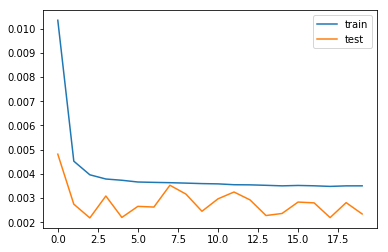

In [51]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)

In [43]:
test_X[:, -6:].shape

(21568, 6)

In [52]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -6:],yhat), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -6:],test_y), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4162.114


In [66]:
(yhat).shape

(13118, 1)

Text(0, 0.5, 'Position (km)')

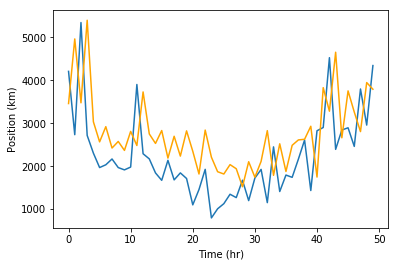

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(inv_y[:50])
plt.plot(inv_yhat[:50],"orange")
plt.xlabel('Time (hr)')
plt.ylabel('Position (km)')

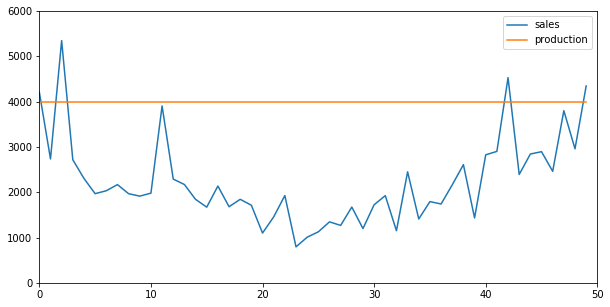

In [55]:
#dumy waste 

## invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_X[:, -6:],test_y), axis=1)
#
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:, -1]


%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(inv_y[:50], label="sales")
plt.plot([4000 for a in range(50)], label="production")
plt.ylim((0,6000))
plt.xlim((0,50))
plt.legend()
plt.show()

## Predict

In [0]:
model.predict(np.append(a[0][:-1], 0).reshape(1,1,13))

In [0]:
import numpy as np
yhat_array = []
i =0
for a in test_X[:50]:
  if i==0:
    yhat = model.predict(np.append(a[0][:-1], 0).reshape(1,1,13))
    yhat_array.append(yhat[0][0])
  else:
    yhat = model.predict( np.append(a[0][:-1], yhat_array[i-1]).reshape(1,1,13))
    yhat_array.append(yhat[0][0])
  
  i+=1

In [0]:
concatenate((test_X[:50, -6:],test_y[:50,:]), axis=1)

In [58]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:50, -6:],np.array(yhat_array).reshape(50,1)), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:50, -6:],test_y[:50,:]), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1052.047


Text(0, 0.5, 'Position (km)')

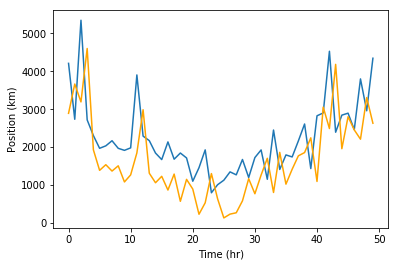

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(inv_y)
plt.plot(inv_yhat,"orange")
plt.xlabel('Time (hr)')
plt.ylabel('Position (km)')

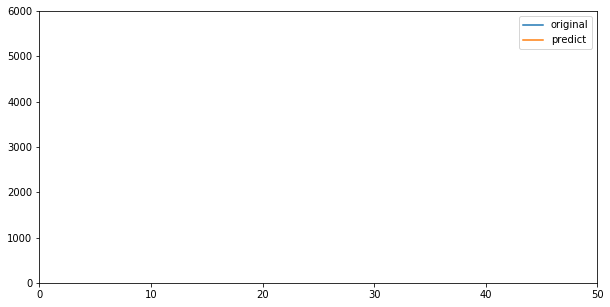

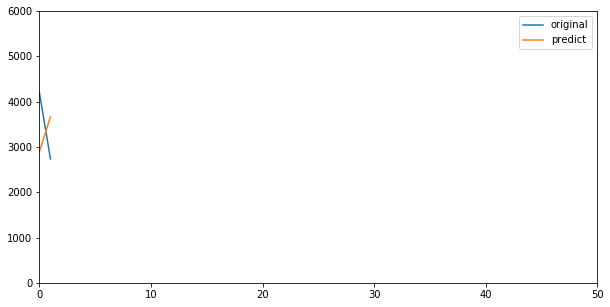

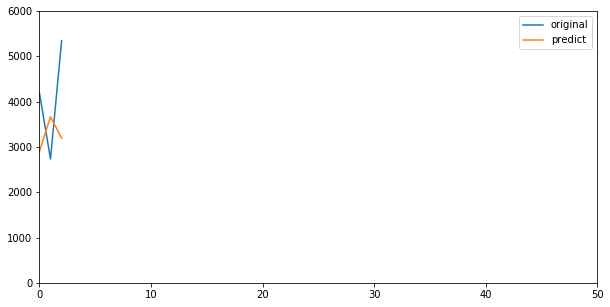

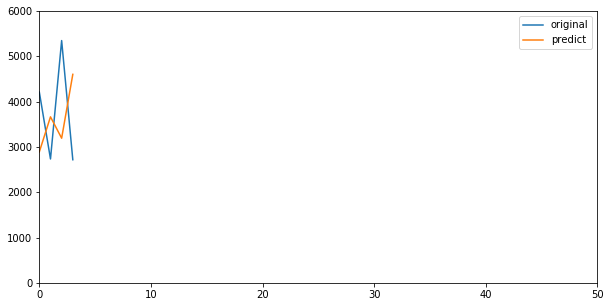

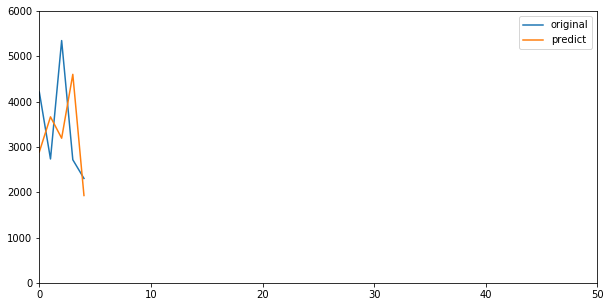

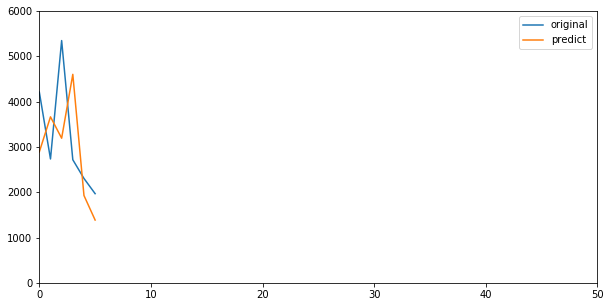

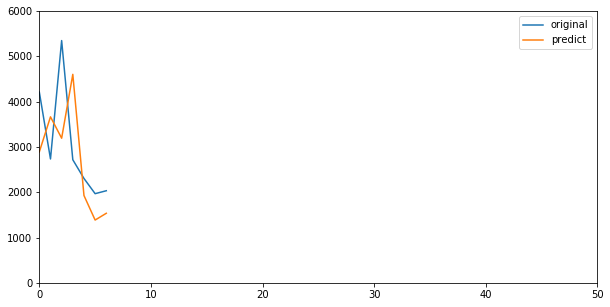

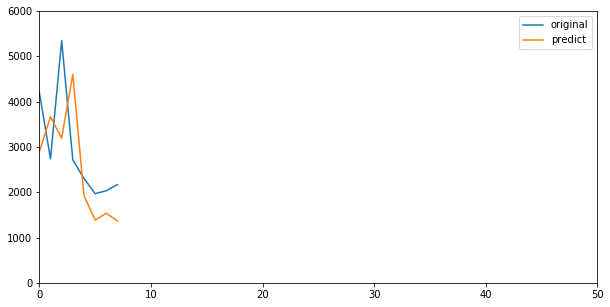

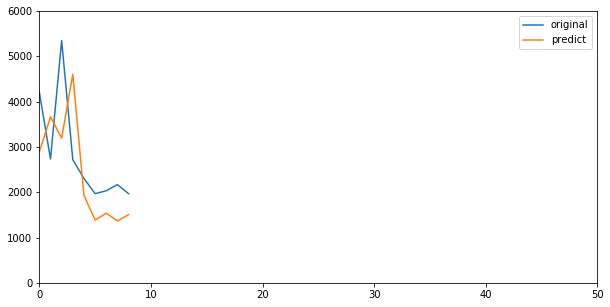

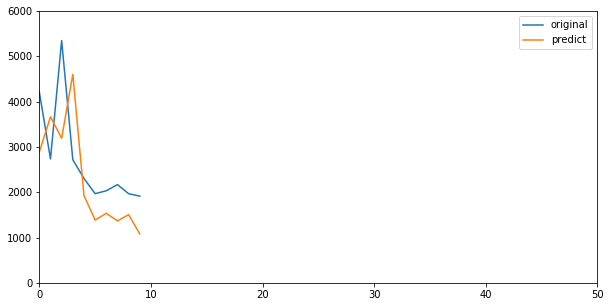

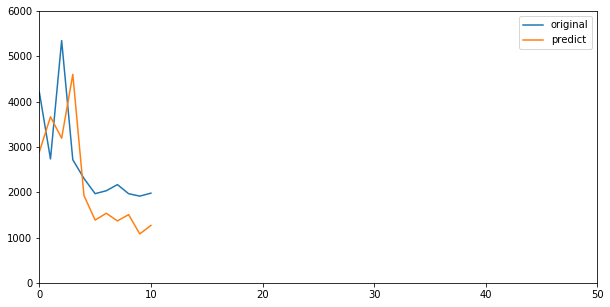

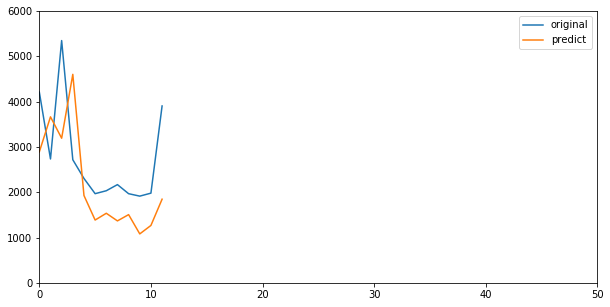

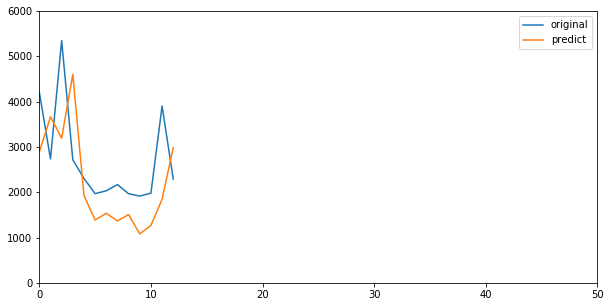

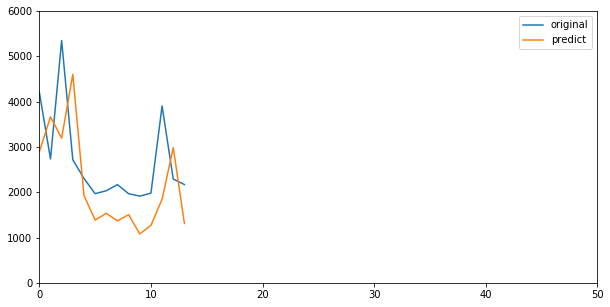

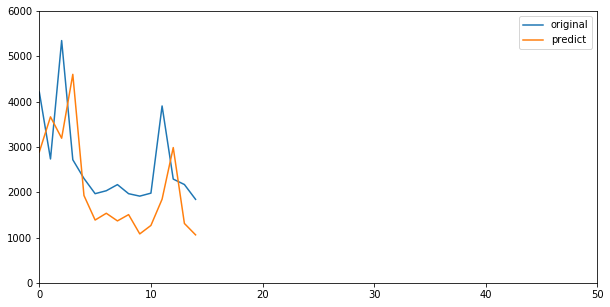

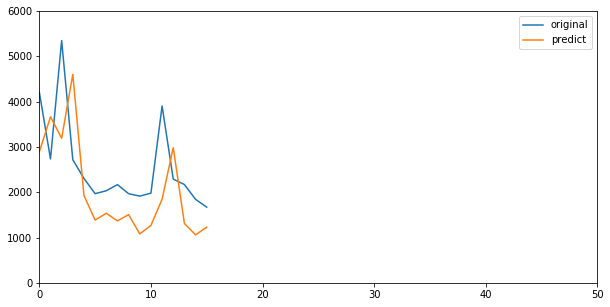

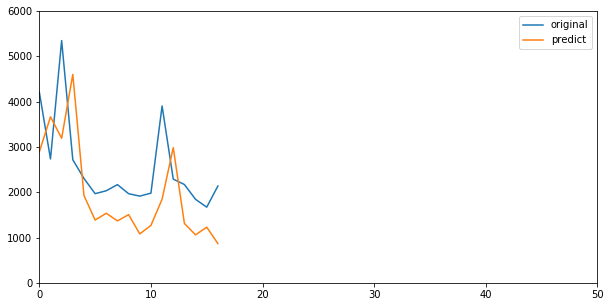

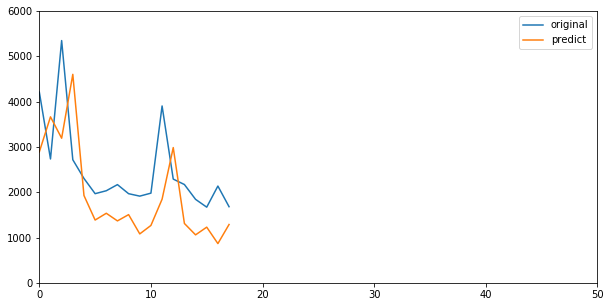

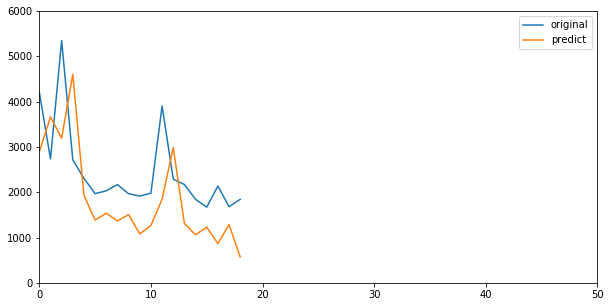

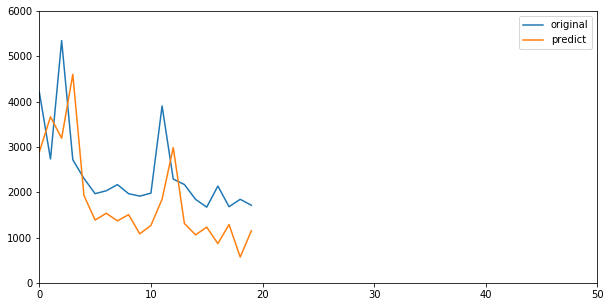

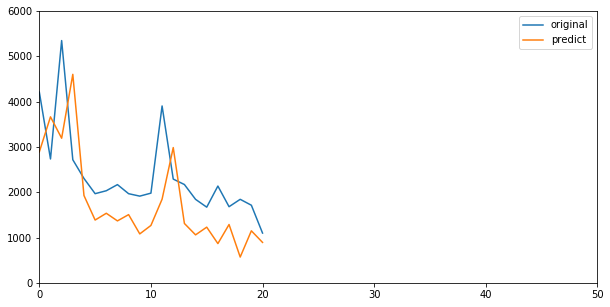

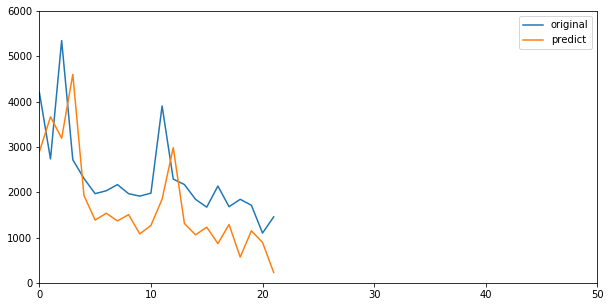

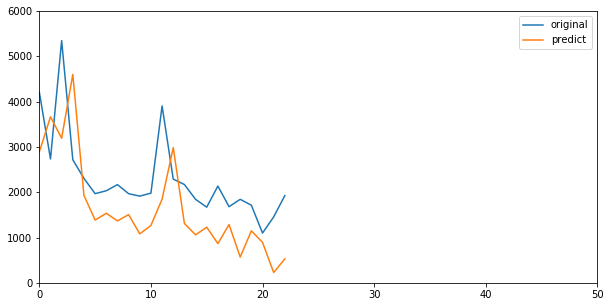

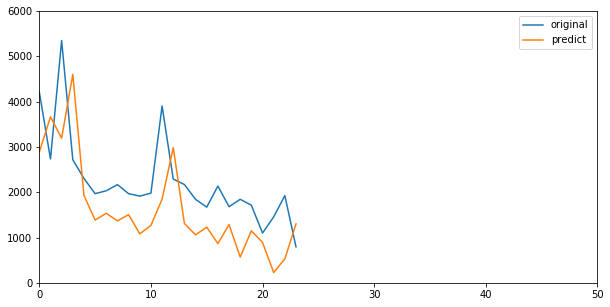

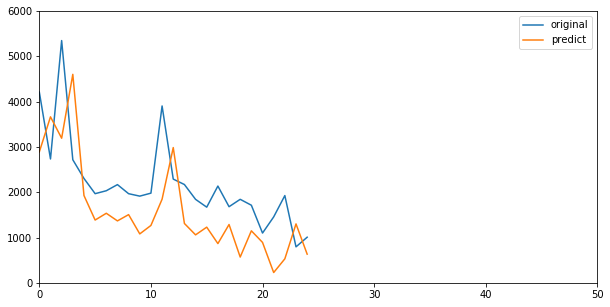

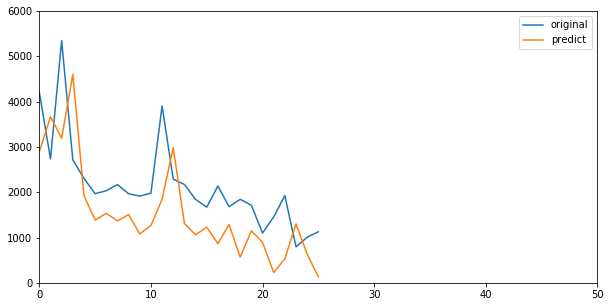

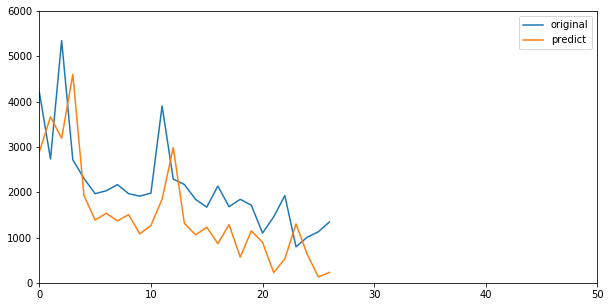

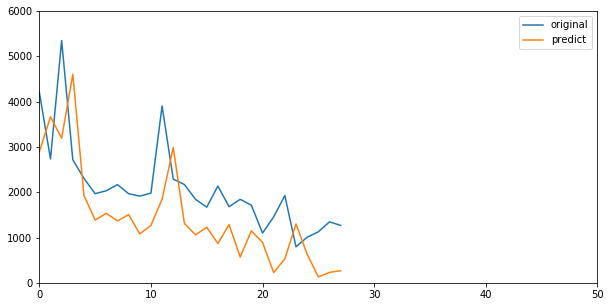

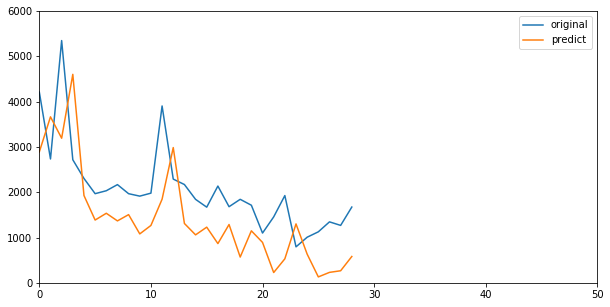

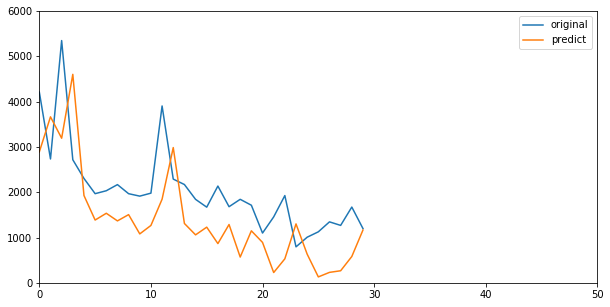

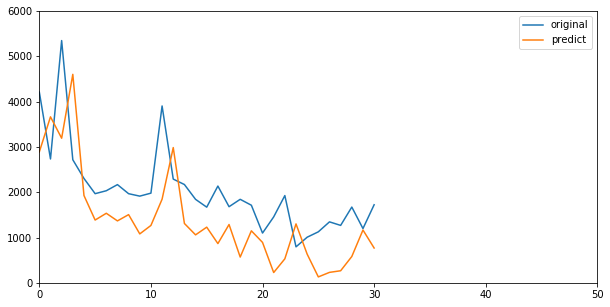

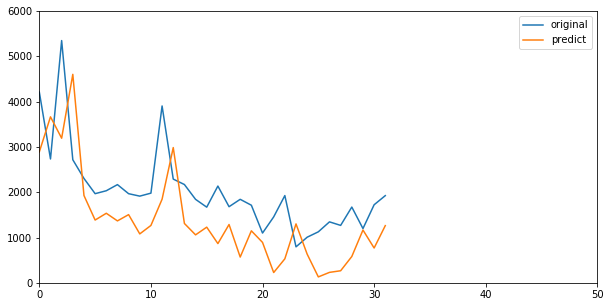

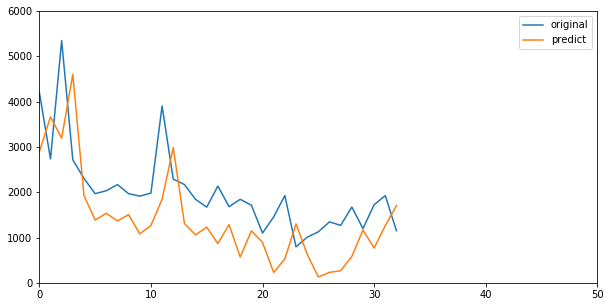

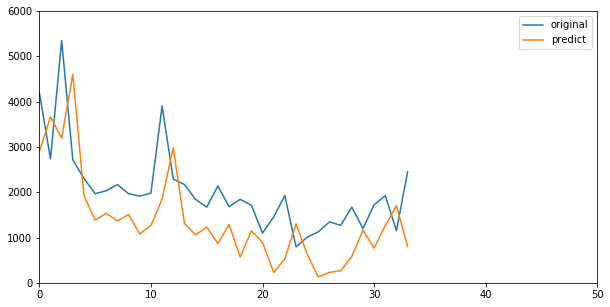

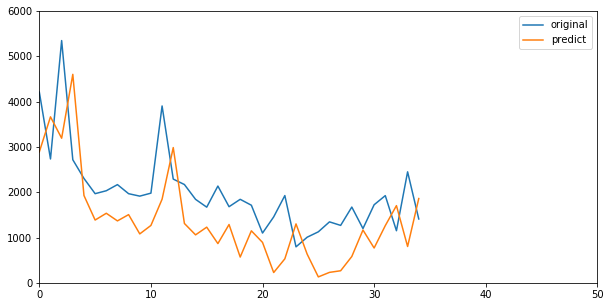

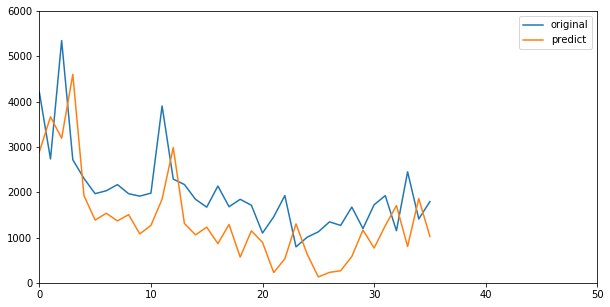

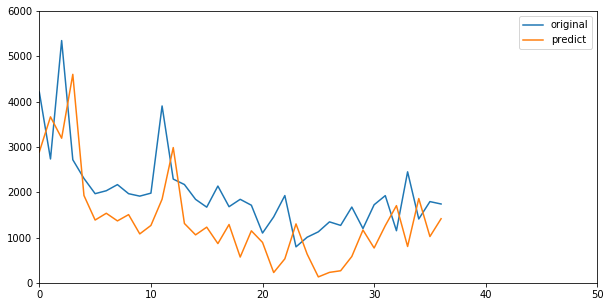

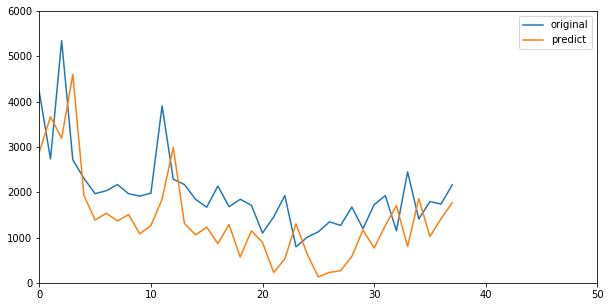

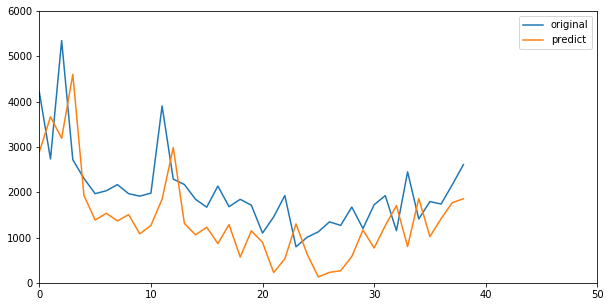

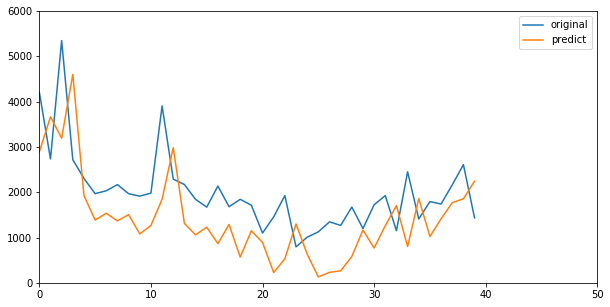

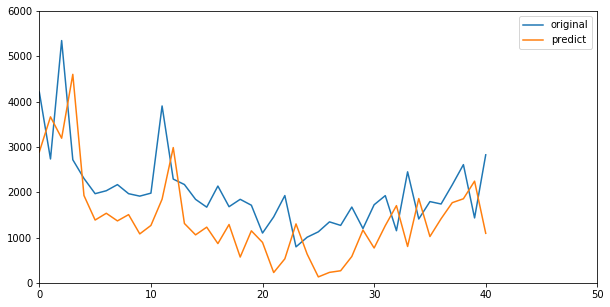

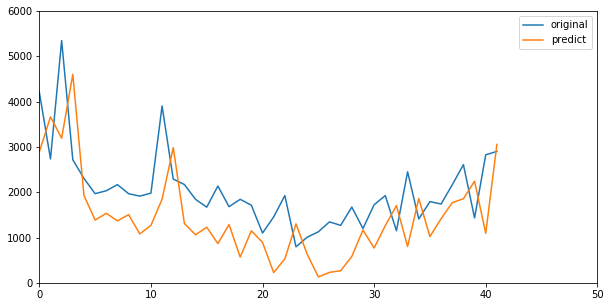

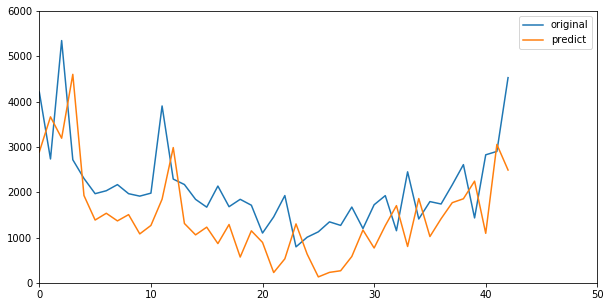

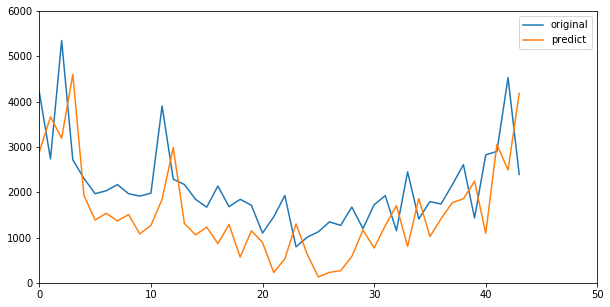

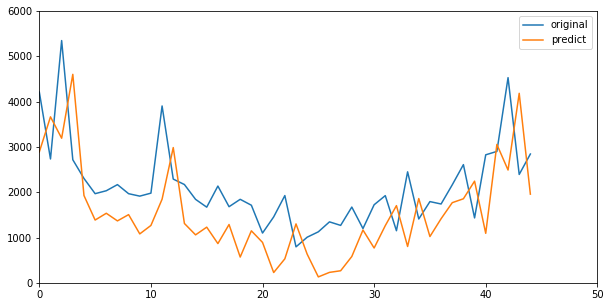

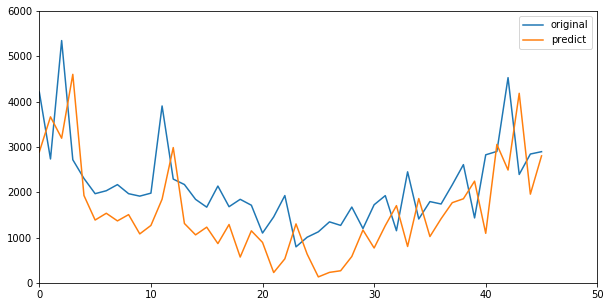

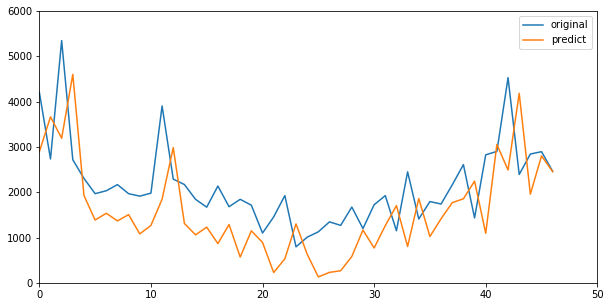

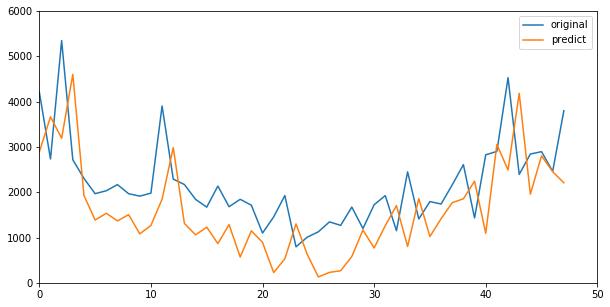

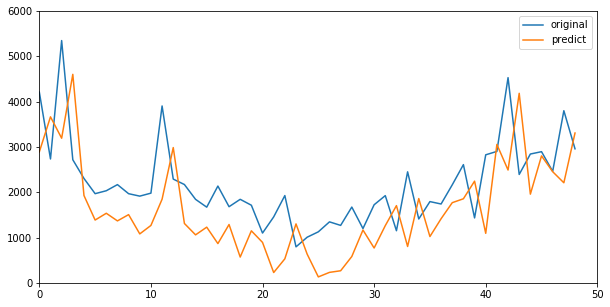

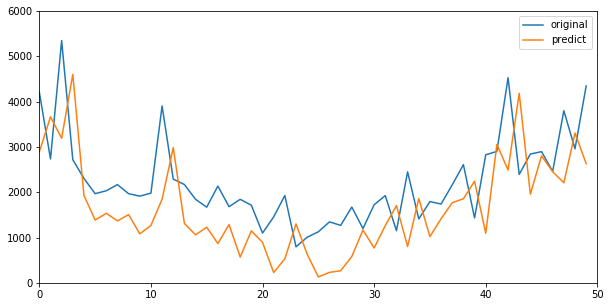

In [60]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
x = []
inv_y_array = []
inv_yhat_array = []
i=0

for in_y in inv_y:
  x.append(i)
  inv_y_array.append(in_y)
  inv_yhat_array.append(inv_yhat[i])
  #clear_output(wait=True)
  plt.figure(figsize=(10,5))

  plt.plot(x, inv_y_array, label="original")
  plt.plot(x, inv_yhat_array, label="predict")
  plt.ylim((0,6000))
  plt.xlim((0,50))
  plt.legend()
  plt.show()
  i+=1

In [0]:
from pandas import read_csv
from datetime import datetime
# load data
dataset_part = read_csv('train.csv')
i=0
before = 0
after = 14000
for a in range(30):
  dataset_part[before:after].to_csv('out/pollution'+str(i)+'.csv')
  before = before + 30
  after = after+30
  i+=1

In [125]:
len(dataset_part)

421570

In [126]:
421570/30

14052.333333333334

In [0]:
!mkdir out

In [130]:
!zip -r output_file.zip out

updating: out/ (stored 0%)
updating: out/pollution25.csv (deflated 73%)
updating: out/pollution5.csv (deflated 73%)
updating: out/pollution19.csv (deflated 73%)
updating: out/pollution28.csv (deflated 73%)
updating: out/pollution21.csv (deflated 73%)
updating: out/pollution24.csv (deflated 73%)
updating: out/pollution8.csv (deflated 73%)
updating: out/pollution26.csv (deflated 73%)
updating: out/pollution10.csv (deflated 73%)
updating: out/pollution29.csv (deflated 73%)
updating: out/pollution7.csv (deflated 73%)
updating: out/pollution11.csv (deflated 73%)
updating: out/pollution23.csv (deflated 73%)
updating: out/pollution15.csv (deflated 73%)
updating: out/pollution20.csv (deflated 73%)
updating: out/pollution13.csv (deflated 73%)
updating: out/pollution0.csv (deflated 73%)
updating: out/pollution9.csv (deflated 73%)
updating: out/pollution4.csv (deflated 73%)
updating: out/pollution6.csv (deflated 73%)
updating: out/pollution18.csv (deflated 73%)
updating: out/pollution27.csv (defl

In [0]:
dataset_partaaa = read_csv('out/pollution5.csv')

In [136]:
len(dataset_partaaa)

14000